# Datatonic OpenLibrary Coding Challenge
## What makes a great book in OpenLibrary? 📚

**Specifically: *What features contribute to the reading preferences of OpenLibrary's users?*** 

**Scoping and Assumptions:**
*Query Scope*
- I will be limiting my query to works that have **at least one readinglog_count**.
- I will initially limit the **first_publish_year to 2019** to run through my operations on a limited dataset before building it out to multiple years

*Measures of popularity and preference*
- I will be using **readinglog_count** and **rating** as the outcome measures.
  - Its important to note that readinglog_count does not indicate the number of times that a book has been borrowed through OpenLibrary, but is a sum of the user-entered fields *want_to_read_count, currently_reading_count,* and *already_read_count*. This means it is not the perfect measure of popularity of a book - ideally we'd use data from the borrowing log, or page clicks. I reached out to the OpenLibrary program manager 'Mek' (Michael...) however he confirmed this data was not available to the public. So we'll have to rely on this for now.

*Features under consideration*
- The following features are being considered to determine which factors are the best predictors (and therefore make the greatest contribution) to the popularity and rating of books for OpenLibrary's users.
  - 'first_publish_year, title, author_name, language, number_of_pages_median,publisher, format, subject, ratings_average, ratings_sortable, ratings_count, readinglog_count, want_to_read_count, currently_reading_count, already_read_count, first_sentence',


In [47]:
"""
Step 1. Construct and Convert the Query with Luqum (to be readable by apache solr, the query type specified in OpenLibrary's documentation)
"""
from luqum.parser import parser
from luqum.pretty import prettify
from luqum.tree import Word, Range

# Create a query for books first published in 2019 and with readinglog_count > 0 and with median number of pages between 1 and 4000[*]
query = parser.parse('first_publish_year:2019 AND readinglog_count:[1 TO *] AND number_of_pages_median:[1 TO 4000]')

# Convert the query to a Solr query string
solr_query = prettify(query)
print(solr_query)

first_publish_year: 2019
AND
readinglog_count: [1 TO *]
AND
number_of_pages_median: [1 TO 4000]


In [68]:
%%time
"""
Step 2. Make API Call
"""
import requests

# OpenLibrary API endpoint
url = 'http://openlibrary.org/search.json'

# Query parameters
params = {
    'q': solr_query,
    'sort': 'random',
    'fields': 'first_publish_year,title,author_name,language,number_of_pages_median,publisher,format,subject,ratings_average,ratings_sortable,ratings_count,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,first_sentence',
    'limit': 50000  # Limit sample of results
}

# Make the API call
response = requests.get(url, params=params)

# Process the response
if response.status_code == 200:
    data = response.json()
    #for book in data.get('docs', []):
        #print(book)
else:
    print(f"Error: {response.status_code}")


CPU times: user 136 ms, sys: 73.2 ms, total: 209 ms
Wall time: 50 s


In [49]:
"""
Step 3. Load dataset into Pandas DataFrame and perform initial data overview
"""

import pandas as pd

data_df = pd.DataFrame.from_records(data['docs'])
data_df.head()

,author_name,first_publish_year,format,language,number_of_pages_median,publisher,title,subject,readinglog_count,want_to_read_count,currently_reading_count,already_read_count,ratings_average,ratings_sortable,ratings_count,first_sentence
0,[Osman Affan],2019,[Softcover],[may],128,[Komik-M],Ultra Smart Study,"[Manga, Graphic Novels, Non-Fiction, Comic Book]",1,0,0,1,NaN,NaN,NaN,NaN
1,[Crystal Cestari],2019,NaN,[eng],320,[Hyperion Books for Children],"Windy City Magic, Book 3 the Fairest Kind of Love","[Children's fiction, Magic, fiction, Love, fic...",1,1,0,0,NaN,NaN,NaN,NaN
2,[Willow Rose],2019,[paperback],NaN,350,"[Independently Published, Independently publis...",LET ME GO,NaN,1,1,0,0,NaN,NaN,NaN,NaN
3,[Rumiko Takahashi],2019,[paperback],NaN,400,[VIZ Media LLC],"Urusei Yatsura, Vol. 2","[Comics & graphic novels, manga, science fiction]",1,0,0,1,NaN,NaN,NaN,NaN
4,[Hydration Press],2019,[paperback],NaN,121,"[Independently published, Independently Publis...","Urine Luck, I Gotta Pee",NaN,1,1,0,0,NaN,NaN,NaN,NaN


In [35]:
data_df.dtypes

author_name                 object
first_publish_year           int64
language                    object
number_of_pages_median       int64
publisher                   object
title                       object
subject                     object
readinglog_count             int64
want_to_read_count           int64
currently_reading_count      int64
already_read_count           int64
format                      object
ratings_average            float64
ratings_sortable           float64
ratings_count              float64
first_sentence              object
dtype: object

Text(0.5, 0.98, 'Plotting outcomes of interest')

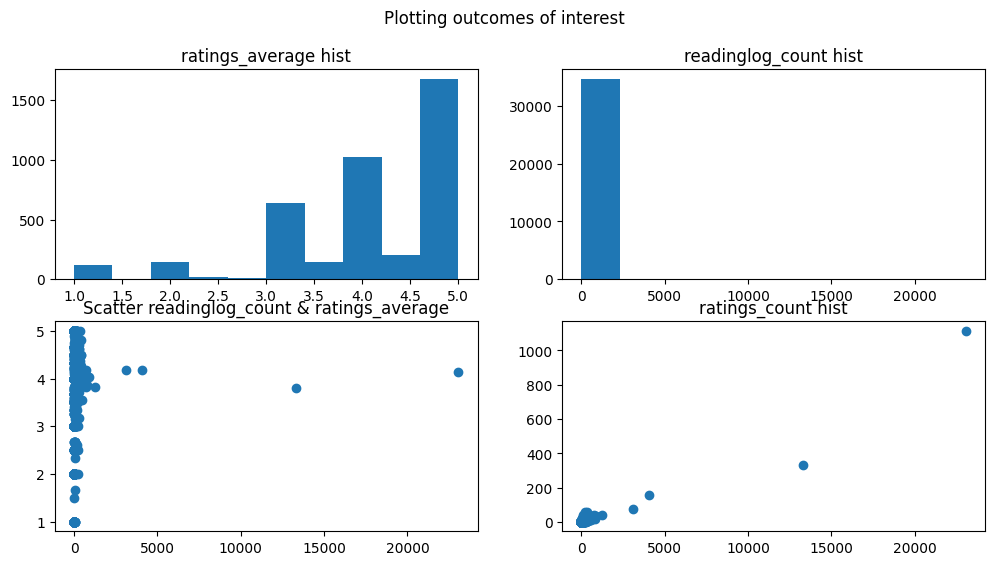

In [50]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axs[0,0].set_title('ratings_average hist')
axs[0,0].hist(data_df['ratings_average'])
axs[0,1].set_title('readinglog_count hist')
axs[0,1].hist(data_df['readinglog_count'])
axs[1,0].set_title('Scatter readinglog_count & ratings_average')
axs[1,0].scatter(data_df['readinglog_count'], data_df['ratings_average'])
axs[1,1].set_title('ratings_count hist')
axs[1,1].scatter(data_df['readinglog_count'], data_df['ratings_count'])
fig.suptitle('Plotting outcomes of interest')


A quick look at the relationship between our two outcomes of interest, readinglog_count and ratings_average, appears to tell us the following:
- The 

(array([ 124.,  172., 1464., 1670.,  307.,  117.,   76.,   33.,   13.,
           7.]),
 array([1.5545194, 1.8171867, 2.079854 , 2.3425213, 2.6051886, 2.8678559,
        3.1305232, 3.3931905, 3.6558578, 3.9185251, 4.1811924]),
 <BarContainer object of 10 artists>)

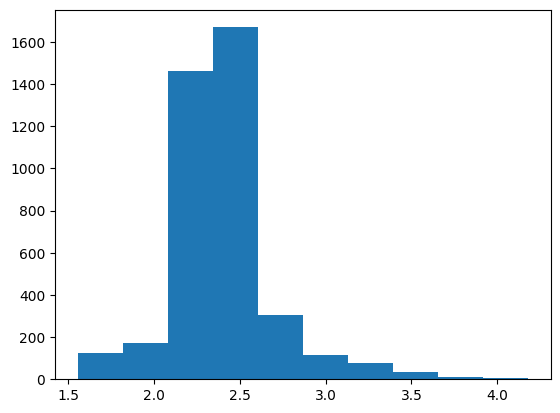

In [37]:
plt.hist(data_df['ratings_sortable'])


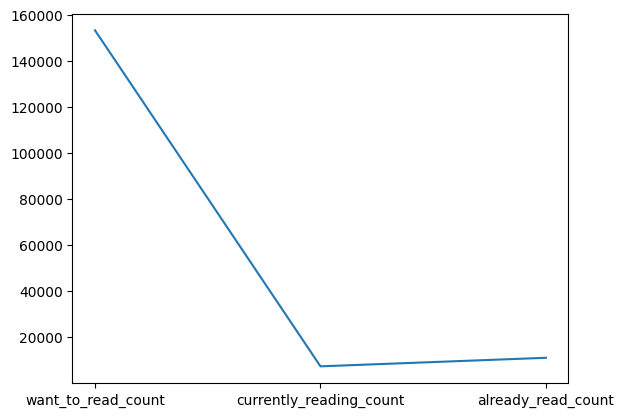

In [51]:
labels = ['want_to_read_count', 'currently_reading_count', 'already_read_count']
sums = []
for label in labels:
    sums.append(data_df[label].sum())

#reading_log_data = {'want_to_read_count' : data_df.['want_to_read_count'].sum(),'currently_reading_count': data_df.['currently_reading_count'].sum() ,'already_read_count': data_df['already_read_count'].sum()}
plt.plot(labels, sums)

Let's clean up the data that we queried for further analysis:
- Null data
- Duplicates
- Outliers
- Scaling Numerical features
- Balancing
- Encoding categorical features

In [52]:
# Check for missing / null data
data_df.isnull().sum().sort_values(ascending=False) / len(data_df)

first_sentence             0.994473
ratings_average            0.884741
ratings_sortable           0.884741
ratings_count              0.884741
subject                    0.506525
language                   0.411436
format                     0.377116
author_name                0.008652
publisher                  0.001418
first_publish_year         0.000000
number_of_pages_median     0.000000
title                      0.000000
readinglog_count           0.000000
want_to_read_count         0.000000
currently_reading_count    0.000000
already_read_count         0.000000
dtype: float64

Conclusion: ~92% of entries are missing ratings data. Meaning that only 8% of books that are read get rated by users.

In [53]:
# Duplicates

# Since it is possible to have the same title for different books AND for one author to have published multiple books, let's
# create a composite column of 'title by author_name'
data_df['title_author'] = data_df.apply(lambda row: f"{row['title']} by {row['author_name']}", axis=1)
print(data_df[['title', 'author_name', 'title_author']].head())

# check duplicates using this composite column 'title_author' compared to others
print(f"Duplicates: title_author: {data_df['title_author'].duplicated().sum()} vs title: {data_df['title'].duplicated().sum()} vs author: {data_df['author_name']}.")

                                               title         author_name  \
0                                  Ultra Smart Study       [Osman Affan]   
1  Windy City Magic, Book 3 the Fairest Kind of Love   [Crystal Cestari]   
2                                          LET ME GO       [Willow Rose]   
3                             Urusei Yatsura, Vol. 2  [Rumiko Takahashi]   
4                            Urine Luck, I Gotta Pee   [Hydration Press]   

                                        title_author  
0               Ultra Smart Study by ['Osman Affan']  
1  Windy City Magic, Book 3 the Fairest Kind of L...  
2                       LET ME GO by ['Willow Rose']  
3     Urusei Yatsura, Vol. 2 by ['Rumiko Takahashi']  
4     Urine Luck, I Gotta Pee by ['Hydration Press']  
Duplicates: title_author: 394 vs title: 1230 vs author: 0                                            [Osman Affan]
1                                        [Crystal Cestari]
2                                      

HANDLE DUPLICATES

<Axes: >

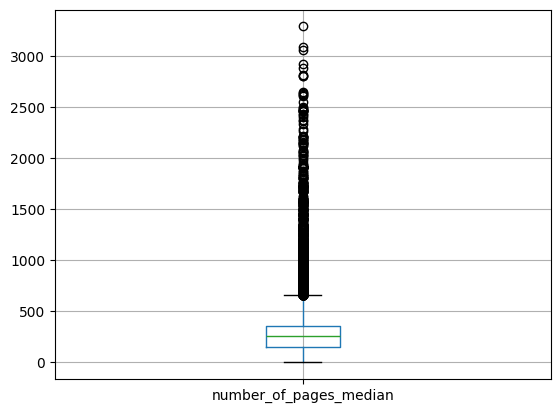

In [54]:
data_df[['number_of_pages_median']].boxplot()


In [55]:
#import numpy as np

# Error at index 1223 for Revel for Essentials of Organizational Behaviour, Second Canadian Edition -- Access Card'
# 'number_of_pages_median' = 99 999 is an error! Checked online and found that it is 432 pages. https://www.amazon.ca/Essentials-Organizational-Behaviour-Second-Canadian/dp/013524160X


max_index = data_df['number_of_pages_median'].idxmax()
max_row = data_df.loc[max_index]
max_row


author_name                                               [Kaplan Test Prep]
first_publish_year                                                      2019
format                                                           [paperback]
language                                                                 NaN
number_of_pages_median                                                  3288
publisher                         [Kaplan Grad Test Prep, Kaplan Publishing]
title                          MCAT Complete 7-Book Subject Review 2020-2021
subject                                                                  NaN
readinglog_count                                                           2
want_to_read_count                                                         2
currently_reading_count                                                    0
already_read_count                                                         0
ratings_average                                                          NaN

In [ ]:
# Scale numerical Features

# Numerical columns
data_df[['first_publish_year','number_of_pages_median','ratings_average','ratings_sortable','ratings_count','readinglog_count','want_to_read_count','currently_reading_count','already_read_count']]
    


Moving forward, let's first consider each of the following separately: 
1. What book features influence reading count from readers?
2. What book features positively influence ratings from readers?
3. How do these features impact ratings_sortable? A feature that combines and weighs the ratings outcome by the number of ratings?

In [70]:
pop_df = data_df[['author_name', 'first_publish_year','format','language','number_of_pages_median','publisher','title','subject','readinglog_count']]

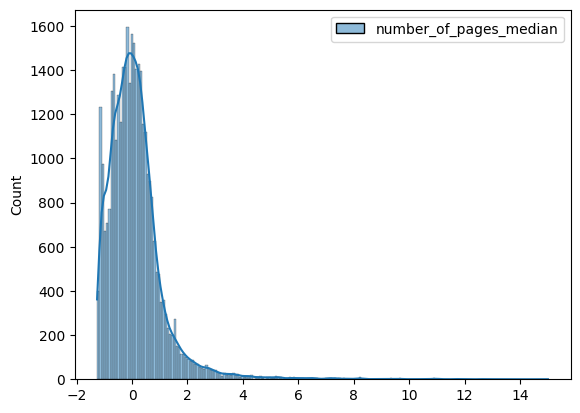

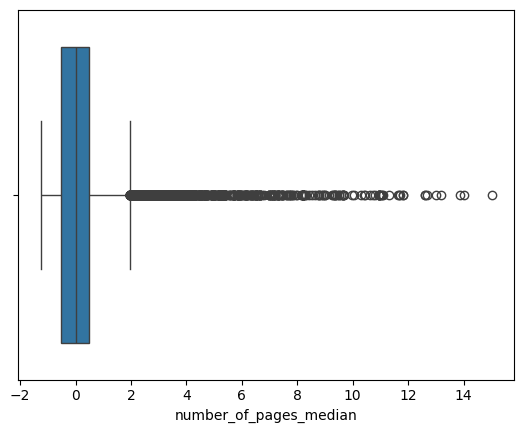

In [71]:
# Target col is readinglog_count = y
# Scale numerical features
import seaborn as sns
fig, axs = plt.subplots(1, 1)
sns.histplot(pop_df[['number_of_pages_median']], bins=200,kde = True);
fig, axs = plt.subplots(1, 1)
sns.boxplot(data=pop_df, x='number_of_pages_median');
#data_df[['number_of_pages_median']]

In [65]:
import numpy as np

In [73]:
from sklearn.preprocessing import RobustScaler

# Step 0 - Instantiate Robust Scaler

rb_scaler = RobustScaler() 

# Step 1 - Fit the scaler to the 'number_of_pages_median'
# to "learn" the median value and the IQR

rb_scaler.fit(pop_df[['number_of_pages_median']])

# Step 2 - Scale / Transform
# to apply the transformation (value - median) / IQR for every house

#data['GrLivArea'] = rb_scaler.transform(data[['GrLivArea']]) 
pop_df['number_of_pages_median'] = rb_scaler.transform(pop_df[['number_of_pages_median']])

pop_df.head()

/var/folders/1g/sdktyfrj7yl34lwprcvwz7t40000gn/T/ipykernel_98404/3153443528.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop_df['number_of_pages_median'] = rb_scaler.transform(pop_df[['number_of_pages_median']])


,author_name,first_publish_year,format,language,number_of_pages_median,publisher,title,subject,readinglog_count
0,[Osman Affan],2019,[Softcover],[may],-0.633663,[Komik-M],Ultra Smart Study,"[Manga, Graphic Novels, Non-Fiction, Comic Book]",1
1,[Crystal Cestari],2019,NaN,[eng],0.316832,[Hyperion Books for Children],"Windy City Magic, Book 3 the Fairest Kind of Love","[Children's fiction, Magic, fiction, Love, fic...",1
2,[Willow Rose],2019,[paperback],NaN,0.465347,"[Independently Published, Independently publis...",LET ME GO,NaN,1
3,[Rumiko Takahashi],2019,[paperback],NaN,0.712871,[VIZ Media LLC],"Urusei Yatsura, Vol. 2","[Comics & graphic novels, manga, science fiction]",1
4,[Hydration Press],2019,[paperback],NaN,-0.668317,"[Independently published, Independently Publis...","Urine Luck, I Gotta Pee",NaN,1


In [74]:
# Categorical columns
x = pop_df[['author_name', 'title', 'language', 'publisher', 'subject']]
y = pop_df[['readinglog_count']]

In [75]:
# Enrich language column to reduce amnt of NaN

# current list of all languages:

unique_langs=['eng']
#cycle through df and add any strings that are not already in the final list
def check_lang(row):
    if isinstance(row['language'], list):
        for lang in row['language']:
            if lang not in unique_langs:
                unique_langs.append(lang)
# for each row
data_df.apply(check_lang, axis=1)

print(unique_langs)


['eng', 'may', 'fre', 'tur', 'ger', 'spa', 'srp', 'por', 'ita', 'hin', 'rus', 'pol', 'ukr', 'dut', 'chi', 'tel', 'vie', 'jpn', 'ara', 'kor', 'dan', 'cat', 'ind', 'heb', 'mao', 'mul', 'hrv', 'bul', 'gre', 'rum', 'per', 'swa', 'wel', 'enm', 'orm', 'sin', 'kur', 'swe', 'iku', 'fin', 'xho', 'cze', 'san', 'alb', 'mal', 'zul', 'pan', 'baq', 'nob', 'hun', 'ben', 'glg', 'sco', 'gla', 'syr', 'asm', 'cmn', 'slo', 'urd']


In [85]:
# Fill in missing languages:
import langid

# langid provides language in  ISO 639-1 whereas OpenLib appears to provide language in ISO 639-3 format
# Here is an ISO 639-1 to ISO 639-3 Mapping Dictionary:
iso639_1_to_3 = {
    'af': 'afr',  # Afrikaans
    'sq': 'sqi',  # Albanian
    'ar': 'ara',  # Arabic
    'hy': 'hye',  # Armenian
    'bn': 'ben',  # Bengali
    'bs': 'bos',  # Bosnian
    'ca': 'cat',  # Catalan
    'hr': 'hrv',  # Croatian
    'cs': 'ces',  # Czech
    'da': 'dan',  # Danish
    'nl': 'nld',  # Dutch
    'en': 'eng',  # English
    'eo': 'epo',  # Esperanto
    'et': 'est',  # Estonian
    'fi': 'fin',  # Finnish
    'fr': 'fra',  # French
    'de': 'deu',  # German
    'el': 'ell',  # Greek
    'gu': 'guj',  # Gujarati
    'he': 'heb',  # Hebrew
    'hi': 'hin',  # Hindi
    'hu': 'hun',  # Hungarian
    'is': 'isl',  # Icelandic
    'id': 'ind',  # Indonesian
    'it': 'ita',  # Italian
    'ja': 'jpn',  # Japanese
    'jw': 'jav',  # Javanese
    'kn': 'kan',  # Kannada
    'km': 'khm',  # Khmer
    'ko': 'kor',  # Korean
    'la': 'lat',  # Latin
    'lv': 'lav',  # Latvian
    'lt': 'lit',  # Lithuanian
    'mk': 'mkd',  # Macedonian
    'ml': 'mal',  # Malayalam
    'mn': 'mon',  # Mongolian
    'mr': 'mar',  # Marathi
    'my': 'mya',  # Burmese
    'ne': 'nep',  # Nepali
    'no': 'nor',  # Norwegian
    'or': 'ori',  # Odia
    'pa': 'pan',  # Punjabi
    'pl': 'pol',  # Polish
    'ps': 'pus',  # Pashto
    'pt': 'por',  # Portuguese
    'pa': 'pan',  # Punjabi
    'ro': 'ron',  # Romanian
    'ru': 'rus',  # Russian
    'sa': 'san',  # Sanskrit
    'sd': 'snd',  # Sindhi
    'si': 'sin',  # Sinhala
    'sk': 'slk',  # Slovak
    'sl': 'slv',  # Slovenian
    'es': 'spa',  # Spanish
    'su': 'sun',  # Sundanese
    'sw': 'swa',  # Swahili
    'sv': 'swe',  # Swedish
    'ta': 'tam',  # Tamil
    'te': 'tel',  # Telugu
    'th': 'tha',  # Thai
    'tr': 'tur',  # Turkish
    'uk': 'ukr',  # Ukrainian
    'ur': 'udm',  # Urdu
    'vi': 'vie',  # Vietnamese
    'cy': 'cym',  # Welsh
    'xh': 'xho',  # Xhosa
    'yi': 'yid',  # Yiddish
    'yo': 'yor',  # Yoruba
    'zu': 'zul'   # Zulu
}

# Function to Identify and Convert Language Codes
def convert_language_code(code):
    # Check if the code is in ISO 639-1
    if len(code) == 2 and code.isalpha():
        # Convert ISO 639-1 to ISO 639-3
        return iso639_1_to_3.get(code, code)
    elif len(code) == 3 and code.isalpha():
        # It's already in ISO 639-3
        return code
    else:
        # Invalid or unknown code
        return None

# Function to identify and add language for NaN values under 'language'
def add_lang(row):
    # For all columns with NaN
    if (not (isinstance(row['language'], list))) and pd.isna(row['language']):
        #print(row['language'])
        # Check language of title
        newlang, _ = langid.classify(row['title'])
        #print(f"{row['title']} is in {newlang}")
        # Convert language into ISO 639-3
        insert_lang = convert_language_code(newlang)
        #print(f"{newlang} is now {insert_lang}")
        # Insert language into list
        row['language'] = [insert_lang]
        # Add to unique languages list
        #check_lang(row['language'])
    return row

data_df = data_df.apply(add_lang, axis=1)


In [77]:
data_df.isna().sum() / len(data_df)

author_name                0.008652
first_publish_year         0.000000
format                     0.377116
language                   0.000000
number_of_pages_median     0.000000
publisher                  0.001418
title                      0.000000
subject                    0.506525
readinglog_count           0.000000
want_to_read_count         0.000000
currently_reading_count    0.000000
already_read_count         0.000000
ratings_average            0.884741
ratings_sortable           0.884741
ratings_count              0.884741
first_sentence             0.994473
title_author               0.000000
dtype: float64

In [ ]:
# Subject 
"""
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Sample DataFrame
df = data_df[['author_name','language','title','subject','readinglog_count']]

# Step 1: Tokenize the subjects and create binary encoding
mlb = MultiLabelBinarizer()
subjects_encoded = mlb.fit_transform(df[['subject']])
subjects_df = pd.DataFrame(subjects_encoded, columns=mlb.classes_)

# Combine the new subject features with the original DataFrame
df = df.drop('subject', axis=1)
df = pd.concat([df, subjects_df], axis=1)
"""

In [ ]:
# Summary statistics
print(df.describe())

In [ ]:
# Extract genres from subject

# List of widely recognized genres
book_genres = [
    "Literary Fiction",
    "Historical Fiction",
    "Science Fiction",
    "Fantasy",
    "Mystery",
    "Thriller",
    "Romance",
    "Horror",
    "Young Adult",
    "Dystopian",
    "Adventure",
    "Crime",
    "Magical Realism",
    "Graphic Novels/Comics",
    "Biography/Autobiography",
    "Memoir",
    "Self-Help",
    "True Crime",
    "History",
    "Travel",
    "Science",
    "Philosophy",
    "Religion/Spirituality",
    "Business/Economics",
    "Health/Fitness",
    "Politics",
    "Essays",
    "Cookbooks",
    "Art/Photography",
    "Poetry",
    "Drama/Play",
    "Short Stories",
    "Children's",
    "New Adult",
    "Chick Lit",
    "Westerns",
    "Classics"
]

#Check in subject for each genre and 

In [84]:
sub_df

,author_name,first_publish_year,format,language,number_of_pages_median,publisher,title,readinglog_count,b,c,e,j,s,t,u
0,[Osman Affan],2019,[Softcover],[may],-0.633663,[Komik-M],Ultra Smart Study,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,[Crystal Cestari],2019,NaN,[eng],0.316832,[Hyperion Books for Children],"Windy City Magic, Book 3 the Fairest Kind of Love",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[Willow Rose],2019,[paperback],NaN,0.465347,"[Independently Published, Independently publis...",LET ME GO,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[Rumiko Takahashi],2019,[paperback],NaN,0.712871,[VIZ Media LLC],"Urusei Yatsura, Vol. 2",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[Hydration Press],2019,[paperback],NaN,-0.668317,"[Independently published, Independently Publis...","Urine Luck, I Gotta Pee",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34552,[Ken Berry],2019,NaN,[eng],0.237624,[Victory Belt Publishing],Common Sense Keto,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34553,"[C. J. Cherryh, Jane S. Fancher]",2019,[hardcover],[eng],0.475248,[DAW],Alliance Rising: The Hinder Stars I (Alliance-...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34554,"[Edgar Cabanas, Eva Illouz, Núria Petit Fontserè]",2019,[paperback],NaN,-0.158416,[Ediciones Paidós],Happycracia,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34555,"[Bart Gauvin, Joel Radunzel]",2019,[hardcover],NaN,1.841584,[Ursus Rising Books],NORTHERN FURY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ValueError: setting an array element with a sequence.

In [ ]:
import seaborn as sns

# Melt the DataFrame to long format for easier plotting
df_melted = df.melt(id_vars=['reading_count'], var_name='subject', value_name='presence')

# Filter only rows where the subject is present
df_melted = df_melted[df_melted['presence'] == 1]

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x='subject', y='reading_count', data=df_melted)
plt.xticks(rotation=90)
plt.title('Box Plot of Reading Count by Subject')
plt.show()


In [ ]:
# Step 3: Split the data into training and test sets
X = df.drop('readinglog_count', axis=1)
y = df['readinglog_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R-squared: {r2_score(y_test, y_pred)}')

# Feature importance
feature_importance = pd.Series(model.coef_, index=X.columns)
print(feature_importance)


In [ ]:
import seaborn as sns

# Correlation
sns.heatmap(round(data_df.corr(),2), ax=axes[0], cmap = "coolwarm", annot = True)
axes[0].set_title('Correlation of numeric cols')

## SUBJECT ANALYSIS USING TFIDF VECTORIZER

In [93]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# DataFrame
subject_df = data_df
subject_df = subject_df.dropna(subset=['subject'])

print(subject_df['subject'].apply(type).value_counts())

subject
<class 'list'>    17053
Name: count, dtype: int64


In [96]:


# Convert keywords to a format suitable for analysis
# Assuming 'subject' column contains lists of keywords
subject_df['subject'] = subject_df['subject'].apply(lambda x: ' '.join(x))

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(subject_df['subject'])
y = subject_df['readinglog_count']



/var/folders/1g/sdktyfrj7yl34lwprcvwz7t40000gn/T/ipykernel_98404/4089501652.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df['subject'] = subject_df['subject'].apply(lambda x: ' '.join(x))


R^2 score: -0.011288135818973588


/Users/caitimac/.pyenv/versions/3.10.6/envs/openlib-env2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32043 (\N{CJK UNIFIED IDEOGRAPH-7D2B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/caitimac/.pyenv/versions/3.10.6/envs/openlib-env2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24335 (\N{CJK UNIFIED IDEOGRAPH-5F0F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/caitimac/.pyenv/versions/3.10.6/envs/openlib-env2/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37096 (\N{CJK UNIFIED IDEOGRAPH-90E8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


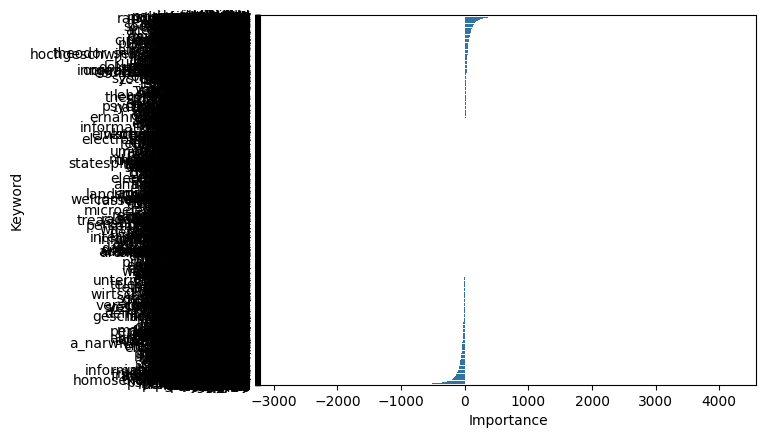

In [97]:
# Linear Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression()
model.fit(X_train, y_train)
print(f'R^2 score: {model.score(X_test, y_test)}')

# Visualization of keyword importance
feature_names = vectorizer.get_feature_names_out()
importance = model.coef_
keywords_importance = pd.DataFrame({'Keyword': feature_names, 'Importance': importance})

sns.barplot(x='Importance', y='Keyword', data=keywords_importance.sort_values(by='Importance', ascending=False))
plt.show()

## SUBJECT ANALYSIS USING MULTILABELBINARIZER

In [99]:
# DataFrame without NaN
sub2_df = data_df.dropna(subset=['subject'])

print(sub2_df['subject'].apply(type).value_counts())

subject
<class 'list'>    17053
Name: count, dtype: int64


In [101]:
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the subject column
subjects_encoded = mlb.fit_transform(sub2_df['subject'])

# Create a DataFrame with the encoded features
subjects_df = pd.DataFrame(subjects_encoded, columns=mlb.classes_)

# Display the encoded DataFrame
print(subjects_df)

# Drop the original subject column
sub2_df = sub2_df.drop('subject', axis=1)

# Concatenate the one-hot encoded features with the original DataFrame
sub2_df = pd.concat([sub2_df, subjects_df], axis=1)

# Display the updated DataFrame
print(sub2_df)

        award:Theodor_Seuss_Geisel_Award  #NoDAPL movement  #crypto  \
0                                      0                 0        0   
1                                      0                 0        0   
2                                      0                 0        0   
3                                      0                 0        0   
4                                      0                 0        0   
...                                  ...               ...      ...   
17048                                  0                 0        0   
17049                                  0                 0        0   
17050                                  0                 0        0   
17051                                  0                 0        0   
17052                                  0                 0        0   

       #earn_money  #earning_money  #finance  #internet  #job  #lootbox  \
0                0               0         0          0     0         0 

In [105]:
sub2_df.head()

,author_name,first_publish_year,format,language,number_of_pages_median,publisher,title,readinglog_count,want_to_read_count,currently_reading_count,...,софтуерна индустрия,умирающий мир,фантастика,الاجتهاد، أصول الفقه، سد الذرائع، القضايا، المعاصرة، الضوابط,Ḥizb-i Islāmī-i Afghānistān,Ṣafavid Dynasty (Iran),‎Murshid kamil,‎mysticism,‎pledge,"紫式部 , b. 978?"
0,[Osman Affan],2019.0,[Softcover],[may],-0.633663,[Komik-M],Ultra Smart Study,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,[Crystal Cestari],2019.0,NaN,[eng],0.316832,[Hyperion Books for Children],"Windy City Magic, Book 3 the Fairest Kind of Love",1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,[Rumiko Takahashi],2019.0,[paperback],[deu],0.712871,[VIZ Media LLC],"Urusei Yatsura, Vol. 2",1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,"[Dean Armstrong QC, Dan Hyde, Sam Thomas]",2019.0,[paperback],[eng],0.495050,"[Bloomsbury Professional, Bloomsbury Publishin...",Blockchain and Cryptocurrency,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,[Ian Sansom],2019.0,[hardcover],[eng],0.475248,"[HarperCollins Canada, Limited, Harper, Harper...","September 1, 1939",1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
